## データダウンロード

In [8]:
# ! mkdir ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.train ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.valid ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.test ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.src.train ./data/eccos/
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.src.valid ./data/eccos/    
! gsutil cp gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.src.test ./data/eccos/    

Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.train...
\ [1 files][  5.7 MiB/  5.7 MiB]                                                
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.valid...
/ [1 files][ 58.7 KiB/ 58.7 KiB]                                                
Operation completed over 1 objects/58.7 KiB.                                     
Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.tgt.test...
| [1 files][  5.7 MiB/  5.7 MiB]                                                
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://wakimoto-ramiel/experiments/exp_20191107_kw2title/data/eccos_mecab_tfidf_top3.src.train...
- [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation compl

## データ整形

In [4]:
def readlines(path):
    with open(path, 'r') as f:
        return [s.replace('\n', '') for s in f.readlines()]

In [10]:
readlines_by_type = lambda _type: readlines(f'./data/eccos/eccos_mecab_tfidf_top3.tgt.{_type}')
train_lines = readlines_by_type('train')
valid_lines = readlines_by_type('valid')
test_lines = readlines_by_type('test')
print(f'data loaded （train:{len(train_lines)}, valid:{len(valid_lines)}, test:{len(test_lines)}）')
# check_data_valid(train_lines, valid_lines, test_lines)

data loaded （train:48011, valid:500, test:48511）


eccosデータだとtrain, valid, testで重複あるので注意

In [11]:
def check_data_valid(train_lines, valid_lines, test_lines):
    train_set = set(train_lines)
    valid_set = set(valid_lines)
    test_set = set(test_lines)
    assert len(train_lines) == len(train_set)
    assert len(valid_lines) == len(valid_set)
    assert len(test_lines) == len(test_set)
    assert len(train_set & valid_set) == 0, f'train, valid は被ってはいけない {len(train_set & valid_set)}件重複'
    assert len(train_set & test_set) == 0, f'train, test は被ってはいけない {len(train_set & test_set)}件重複'
    assert len(valid_set & test_set) == 0, f'valid, test は被ってはいけない {len(valid_set & test_set)}件重複'

### ⛄ eccos限定処理： trainを3分割

In [13]:
lines = readlines(f'./data/eccos/eccos_mecab_tfidf_top3.tgt.train')
kws = readlines(f'./data/eccos/eccos_mecab_tfidf_top3.src.train')

In [15]:
from sklearn.model_selection import train_test_split
def extract_src_tgt(src_tgt_list):
    src_list = [src for src, tgt in src_tgt_list]
    tgt_list = [tgt for src, tgt in src_tgt_list]
    return src_list, tgt_list

def split_train_valid_test(src_list, tgt_list):
    assert len(src_list) == len(tgt_list)
    src_tgt_list = list(zip(src_list, tgt_list))
    train_valid, test = train_test_split(src_tgt_list, train_size=0.8, test_size=0.2)
    train, valid = train_test_split(train_valid, train_size=0.8, test_size=0.2)
    print(f'split train:{len(train)}, valid:{len(valid)}, test:{len(test)}')
    train_src, train_tgt = extract_src_tgt(train)
    valid_src, valid_tgt = extract_src_tgt(valid)    
    test_src, test_tgt = extract_src_tgt(test) 
    return train_src, train_tgt, valid_src, valid_tgt, test_src, test_tgt

In [17]:
train_src, train_tgt, valid_src, valid_tgt, test_src, test_tgt = split_train_valid_test(kws, lines)
check_data_valid(train_tgt, valid_tgt, test_tgt)

split train:30726, valid:7682, test:9603


In [42]:
pd.set_option("display.max_colwidth", 500) # 1セルに500文字入る
pd.set_option("display.max_rows", 100) # 100行表示できる

In [47]:
import pandas as pd
df = pd.DataFrame({'src': train_src, 'tgt': train_tgt})
df['tgt-text'] = df.tgt.apply(lambda t: t.replace(' ', ''))
df.sample(10)[['src', 'tgt-text']]

,src,tgt-text
17018,引き算 近道 美肌,美肌への近道は「引き算」でした!満足度<num>%のスキンケアアイテム
23083,声 多数 買う,買ってよかった!の声多数。ぷるぷる唇をつくる<person>「ルージュティント」全色レビュー
5492,吹っ飛ぶ 憂鬱 気分,ああ、これが五月病?憂鬱な気分を吹っ飛ばして、明日の楽しみを迎えに行きましょう♩
13722,増量 送料 無料,約<num>日分増量中!+送料無料
27514,時代 モテる 女の子,「女の子はおバカな方がモテるんだよ」っていつの時代の話?‘自分らしさ'を大切にしながら、愛され<person>になりましょう。
4805,話 気づく 夜,"気づけば夜。でも話足りない、そんな日もありますよね♡``夜カフェ""でゆっくり夜の時間を楽しみましょう!"
5990,クッション スキンケア 毛穴,毛穴かくれんぼしながらスキンケア。薄型クッションファンデ
22169,サイズ プラス ダイエット,「ナイキ」のプラスサイズマネキンに賛否両論ダイエット会社<person>は「社会にポジティブな影響」と支持
20913,私服 毎日 おしゃれ,毎日、おしゃれな私服ってしんどくない?シーンに合わせた<person>/offコーデで頑張らずにおしゃれ<person>に♡
30557,密着 ひと まつ毛,ひと塗りでまつ毛にも密着!長時間ロングまつ毛をキープ


In [23]:
def save_lines(lines, path):
    with open(path, 'w') as f:
        f.write('\n'.join(lines))

In [24]:
# ! rm ./data/eccos/ptb.train.json ./data/eccos/ptb.valid.json ./data/eccos/ptb.vocab.json 

In [41]:
! mkdir ./data/eccos/tgt
! mkdir ./data/eccos/src
save_lines(train_tgt, './data/eccos/tgt/ptb.train.txt')
save_lines(valid_tgt, './data/eccos/tgt/ptb.valid.txt')
save_lines(test_tgt, './data/eccos/tgt/ptb.test.txt')
save_lines(train_src, './data/eccos/src/ptb.train.txt')
save_lines(valid_src, './data/eccos/src/ptb.valid.txt')
save_lines(test_src, './data/eccos/src/ptb.test.txt')

## 文長分析

`max_sequence_length` 用

In [30]:
import pandas as pd
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_rows", 101)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [31]:
def plot_word_count(lines, normalize=False, label=None):
    lines = list(set(lines))
    words_list = [line.split(' ') for line in lines]
    df_line = pd.DataFrame({'line':lines, 'words':words_list})
    df_line['word_count'] = df_line.words.apply(lambda ws: len(ws))
    
    ser_word_count = df_line.groupby('word_count').count().line
    ser_word_count = ser_word_count/df_line.shape[0] if normalize else ser_word_count
    ser_word_count.plot(alpha=0.5, label=label)
    return df_line

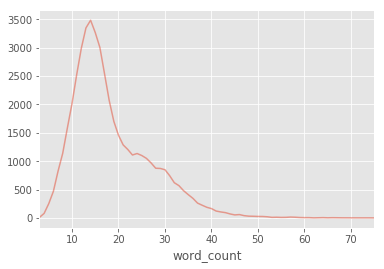

In [32]:
all_tgt = train_tgt + valid_tgt + test_tgt
df_line = plot_word_count(all_tgt)
plt.savefig('./figs/eccos_word_count.png', dpi=120)

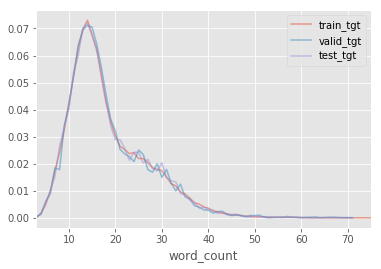

In [34]:
_ = plot_word_count(train_tgt, normalize=True, label='train_tgt')
_ = plot_word_count(valid_tgt, normalize=True, label='valid_tgt')
_ = plot_word_count(test_tgt, normalize=True, label='test_tgt')

plt.legend()

In [165]:
exam_lines_train = readlines('./data/simple-examples/ptb.train.txt')
exam_lines_valid = readlines('./data/simple-examples/ptb.valid.txt')
exam_lines_test = readlines('./data/simple-examples/ptb.test.txt')
print(f'example train:{len(exam_lines_train)}, valid:{len(exam_lines_valid)}, test:{len(exam_lines_test)}')

example train:42068, valid:3370, test:3761


simple-examples train lines: 42068


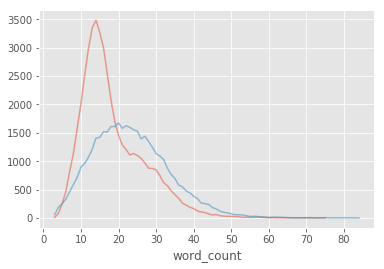

In [166]:
print(f'simple-examples train lines: {len(exam_lines)}')
_ = plot_word_count(all_lines)
_ = plot_word_count(exam_lines)

### 👀 文長ごとのコピーはどんなものかの確認

In [167]:
df_line[df_line.word_count > 40][:3]

,line,words,word_count
92,お 買い物 は 至福 の 時間 な のに 、 いつも お 財布 と 相談 し ながら しない と いけ ない 。 ショッピング 上手 に なる ため の チェックリスト を 活用 し て 、 スマート に お 買い物 を し ましょ う !,"[お, 買い物, は, 至福, の, 時間, な, のに, 、, いつも, お, 財布, と, 相談, し, ながら, しない, と, いけ, ない, 。, ショッピング, 上手, に, なる, ため, の, チェックリスト, を, 活用, し, て, 、, スマート, に, お, 買い物, を, し, ましょ, う, !]",42
99,月 に 一 度 の 待ち に 待ちわび た 、 給料日 が 今月 も やってき た ー ! 今月 の お 給料 は 、 <num> aw の 自己投資 と ゲット す べき アイテム に 使っ て み ませ ん か ?,"[月, に, 一, 度, の, 待ち, に, 待ちわび, た, 、, 給料日, が, 今月, も, やってき, た, ー, !, 今月, の, お, 給料, は, 、, <num>, aw, の, 自己投資, と, ゲット, す, べき, アイテム, に, 使っ, て, み, ませ, ん, か, ?]",41
165,「 毛穴 は 一体 どこ に ある の ?」 と 言い たく なる くらい 綺麗 な お 肌 の 秘密 は 、 ナイト ケア に ある みたい 。 <num> つ の 肌 活 で 、 誰か ら も 羨まし がら れる 素肌 を 手 に 入れ ましょ う ♡,"[「, 毛穴, は, 一体, どこ, に, ある, の, ?」, と, 言い, たく, なる, くらい, 綺麗, な, お, 肌, の, 秘密, は, 、, ナイト, ケア, に, ある, みたい, 。, <num>, つ, の, 肌, 活, で, 、, 誰か, ら, も, 羨まし, がら, れる, 素肌, を, 手, に, 入れ, ましょ, う, ♡]",49
